# Classification

Import the libraries necessary to analize data

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydotplus
import scikitplot as skplt
import seaborn as sns
from IPython.display import Image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import precision_score, recall_score, classification_report
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier,  export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

In [2]:
df = pd.read_csv('../Task1/df_after_dp.csv', parse_dates=['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166664 entries, 0 to 166663
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       166664 non-null  datetime64[ns]
 1   state                      166664 non-null  object        
 2   city_or_county             166664 non-null  object        
 3   latitude                   166664 non-null  float64       
 4   longitude                  166664 non-null  float64       
 5   congressional_district     166664 non-null  int64         
 6   avg_age_participants       166664 non-null  float64       
 7   n_participants_child       166664 non-null  int64         
 8   n_participants_teen        166664 non-null  int64         
 9   n_females                  166664 non-null  float64       
 10  n_killed                   166664 non-null  float64       
 11  n_injured                  166664 non-null  float64 

In [3]:
#check if there is any null value
df.isnull().values.any()

False

The classification task requires to predict whether in the incident there were killed people. Hence we create the binary attribute isKilled

In [4]:
df['isKilled'] = np.where(df['n_killed'] > 0, 1, 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166664 entries, 0 to 166663
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       166664 non-null  datetime64[ns]
 1   state                      166664 non-null  object        
 2   city_or_county             166664 non-null  object        
 3   latitude                   166664 non-null  float64       
 4   longitude                  166664 non-null  float64       
 5   congressional_district     166664 non-null  int64         
 6   avg_age_participants       166664 non-null  float64       
 7   n_participants_child       166664 non-null  int64         
 8   n_participants_teen        166664 non-null  int64         
 9   n_females                  166664 non-null  float64       
 10  n_killed                   166664 non-null  float64       
 11  n_injured                  166664 non-null  float64 

## Discretize categorical values

We discretize the categorical values to use them in the classification task

In [5]:
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [6]:
to_discretize = ['date', 'state', 'city_or_county', 'party']
df = discretize_data(df, to_discretize)

Dropping non-discretized columns

In [7]:
df.drop(columns=['date', 'state', 'city_or_county', 'party'], axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166664 entries, 0 to 166663
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   latitude                   166664 non-null  float64
 1   longitude                  166664 non-null  float64
 2   congressional_district     166664 non-null  int64  
 3   avg_age_participants       166664 non-null  float64
 4   n_participants_child       166664 non-null  int64  
 5   n_participants_teen        166664 non-null  int64  
 6   n_females                  166664 non-null  float64
 7   n_killed                   166664 non-null  float64
 8   n_injured                  166664 non-null  float64
 9   n_arrested                 166664 non-null  float64
 10  n_unharmed                 166664 non-null  float64
 11  n_participants             166664 non-null  float64
 12  incident_characteristics1  166664 non-null  object 
 13  povertyPercentage          16

## Eliminating dependent columns

<Axes: >

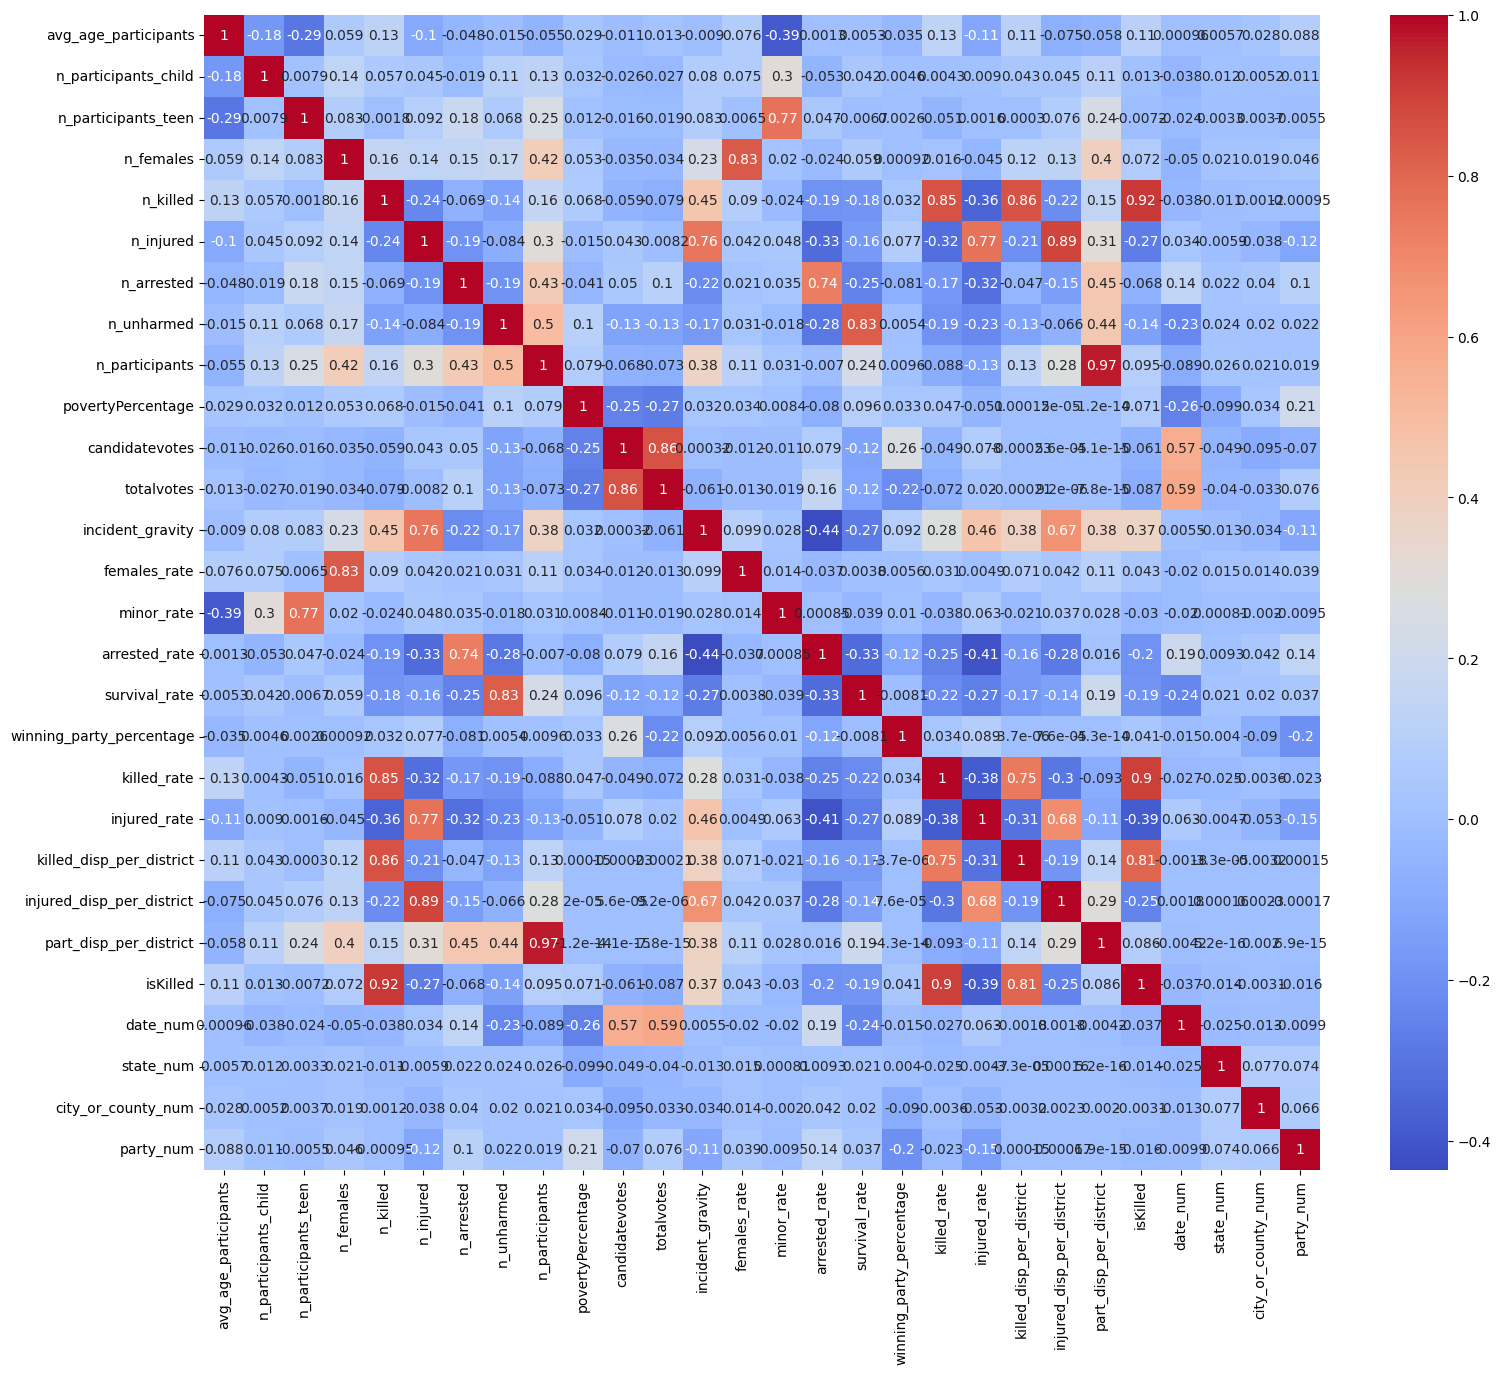

In [8]:
col_to_plot = [i for i in list(df.columns) if i not in ['latitude', 'longitude', 'date','congressional_district']] 
corr_matrix_ind = df[col_to_plot].corr(numeric_only=True, method='pearson')
plt.figure(figsize=(18,15))
sns.heatmap(corr_matrix_ind, annot=True, cmap='coolwarm')

In [9]:
df[(df['n_killed'] == (df["n_participants"] - (df["n_injured"] + df["n_unharmed"] + df["n_arrested"])))][["n_participants","n_killed","n_injured","n_unharmed","n_arrested"]]

,n_participants,n_killed,n_injured,n_unharmed,n_arrested
0,1.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,1.0
3,1.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
166659,3.0,0.0,0.0,3.0,0.0
166660,3.0,0.0,0.0,3.0,0.0
166661,3.0,0.0,1.0,2.0,0.0
166662,5.0,0.0,3.0,2.0,0.0


We drop all the cluster indicators as they are all highly correlated with original features, moreover we decide to drop also latitude and longitude as they represent a sort of incident id (each incident has a unique couple of values after the data preparation), n_killed because highly correlated with isKilled, candidatevotes and totalvotes because they are irrilevant and add only further details to the majority winning party represented already by the attribute party. 

We eliminate also incident_characteristics1 because we think it will simplify too much the task providing a label for each incident.

Moreover, as:

1- so far in the dataset almost the total number of records respect a linear relation n_killed (highly correlated with isKilled) == (df["n_participants"] - (df["n_injured"] + df["n_unharmed"] + df["n_arrested"])) as observed above;

2- we verified that simple baseline methods like logistic regression and k-nn with this setting of features reach above almost 95% of accuracy and 90% of precision, recall, f1, 

we decide to drop also n_injured and n_unharmed, because we consider them harder to find by police w.r.t. n_arrested, as they can grow in time and can be uncertain, and we prefer to leave more general information represented by n_participants.


In [10]:
col_to_drop = ['latitude', 'longitude', 'n_killed', 'n_injured', 'n_unharmed', 'candidatevotes', 'totalvotes', 'incident_characteristics1', 'incident_gravity', 'females_rate',
       'minor_rate', 'arrested_rate', 'survival_rate',  'killed_rate', 'injured_rate',
       'killed_disp_per_district', 'injured_disp_per_district',
       'part_disp_per_district', 'winning_party_percentage']

df.drop(columns=col_to_drop, axis=1,inplace=True)

<Axes: >

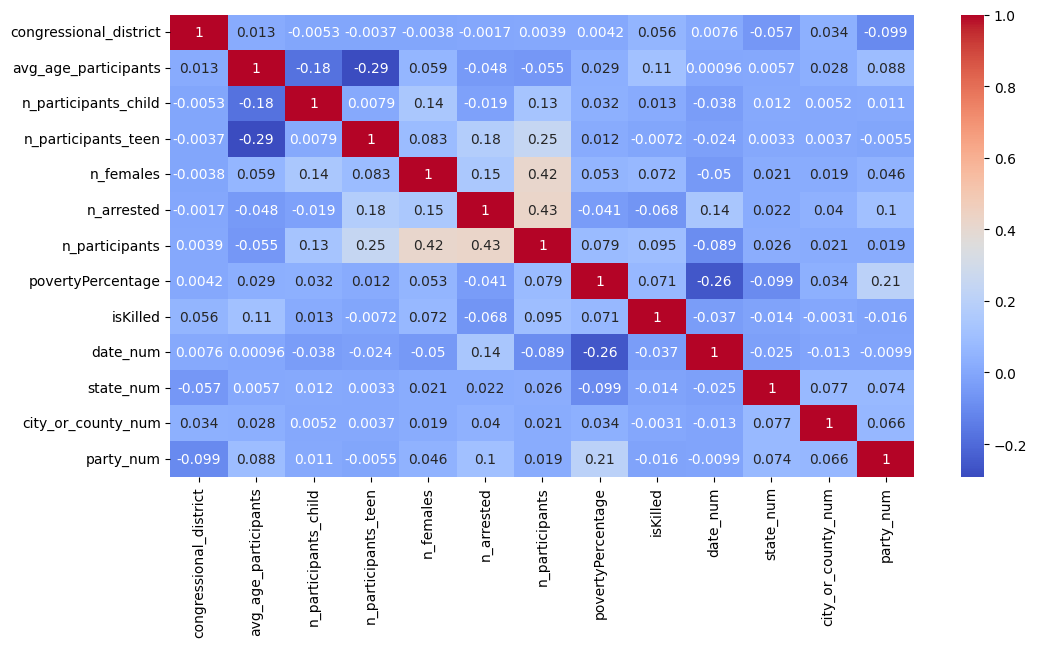

In [11]:
plt.figure(figsize=(12,6))
corr_matrix_ind = df.corr(numeric_only=True, method='pearson')
corr_matrix_ind
sns.heatmap(corr_matrix_ind, annot=True, cmap='coolwarm')

## Classification setup

Check label distribution in order to understand if our dataset is unbalanced towards the negative label (no kill), 23% of labels is positive indeed. 

In [12]:
df['isKilled'].value_counts(True)

isKilled
0    0.736896
1    0.263104
Name: proportion, dtype: float64

Defining a "label" variable for using stratified methods

In [13]:
label = df.pop('isKilled')

We partitioned the dataset into training, validation, and test sets using a 70/30 split.

In [14]:
X_trvl, X_test, y_trvl, y_test = train_test_split(df, label, test_size=0.30,random_state=10, stratify=label)

We standardize data and use oversampling and undersampling techniques to help classification methods to perform better 

over/undersampling on scaled dataset

In [15]:
scaler = StandardScaler()
X_sc_trvl = scaler.fit_transform(X_trvl)
X_sc_test = scaler.fit_transform(X_test)

print(y_trvl.value_counts(True))


oversample = RandomOverSampler(sampling_strategy='minority',random_state=15)
X_sc_trvl_oversampled, y_trvl_oversampled = oversample.fit_resample(X_sc_trvl, y_trvl)
print(y_trvl_oversampled.value_counts(True))


undersample = RandomUnderSampler(sampling_strategy='majority',random_state=15)
X_sc_trvl_undersample, y_trvl_undersample = undersample.fit_resample(X_sc_trvl, y_trvl)
print(y_trvl_undersample.value_counts(True))


isKilled
0    0.736894
1    0.263106
Name: proportion, dtype: float64
isKilled
0    0.5
1    0.5
Name: proportion, dtype: float64
isKilled
0    0.5
1    0.5
Name: proportion, dtype: float64


over/undersampling on not scaled dataset

In [16]:
print(y_trvl.value_counts(True))


oversample = RandomOverSampler(sampling_strategy='minority',random_state=15)
X_trvl_oversampled, y_trvl_oversampled = oversample.fit_resample(X_trvl, y_trvl)
print(y_trvl_oversampled.value_counts(True))


undersample = RandomUnderSampler(sampling_strategy='majority',random_state=15)
X_trvl_undersample, y_trvl_undersample = undersample.fit_resample(X_trvl, y_trvl)
print(y_trvl_undersample.value_counts(True))

isKilled
0    0.736894
1    0.263106
Name: proportion, dtype: float64
isKilled
0    0.5
1    0.5
Name: proportion, dtype: float64
isKilled
0    0.5
1    0.5
Name: proportion, dtype: float64


In [17]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Defining some utility functions

In [18]:
def print_metrics_cv(results_hp_search, model_name):
    index_best_model = results_hp_search.best_index_ 
    results_dict = results_hp_search.cv_results_
    metrics_list=['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    if model_name == 'MLP':
        metrics_list.append('mse')
    print(f"CV best configuration for {model_name}:")
    print(f"best parameters {results_dict['params'][index_best_model]}")
    for i in metrics_list:        
        if i == 'mse':
            print(f'Mean {i} train set: {abs(results_dict[f"mean_train_{i}"][index_best_model])} +/- {results_dict[f"std_train_{i}"][index_best_model]}')
            continue
        print(f'Mean {i} train set: {results_dict[f"mean_train_{i}"][index_best_model]} +/- {results_dict[f"std_train_{i}"][index_best_model]}')
    print("\n")
    for i in metrics_list:
        if i == 'mse':
            print(f'Mean {i} train set: {abs(results_dict[f"mean_test_{i}"][index_best_model])} +/- {results_dict[f"std_test_{i}"][index_best_model]}')
            continue
        print(f'Mean {i} validation set: {results_dict[f"mean_test_{i}"][index_best_model]} +/- {results_dict[f"std_test_{i}"][index_best_model]}')
    print("\n")

In [19]:
# Function that prints the classification report
def print_report_score(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['NotKilled', 'isKilled']))

# Function that prints the confusion matrix
def print_confusion_matrix(test_label, pred_label, model):
    cm = confusion_matrix(test_label, pred_label)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

In [20]:
# Function extracting each grid from dictionary of grids
def list_grids(grids_dict):
    return [grids_dict[item] for item in grids_dict]

# Function performing gridsearch cv according to sklearn
def do_sklearn_GridSearchCV(model_name,model,param_grid,scoring,refit,cv,return_train_score,n_jobs,X_encoded,y):
    hp_search = GridSearchCV(model,
                                param_grid=param_grid,
                                scoring=scoring,
                                refit=refit,
                                cv=cv,
                                return_train_score=return_train_score,
                                n_jobs=n_jobs,
                                verbose=10
                                ).fit(X_encoded, y)


    results = pd.DataFrame(hp_search.cv_results_)
    if not os.path.isdir(f"cv_results/"):
        os.mkdir(f"cv_results/")

    results.to_csv(f"cv_results/{model_name}_cv_results.csv")

    return hp_search

## Logistic Regression

Attempt with only class weights (described in report)

In [23]:
""" params = {
       "l1": {"solver": ['saga', 'liblinear'],
              "C": [1e-1, 1e1, 1e4],
              "penalty": ['l1'],
              "class_weight":['balanced', None, {0: 0.3, 1: 0.7}, {0:1,1:2}]
              },
       "l2": {"solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga', 'newton-cholesky'],
              "C": [1e-1, 1e1, 1e4],
              "penalty": ['l2'],
              "class_weight":['balanced', None, {0: 0.3, 1: 0.7}, {0:1,1:2}]
              },
       "elastic-net": {"solver": ['saga'],
                     "C": [1e-1, 1e1, 1e4],
                     "penalty": ['elasticnet'],
                     "l1_ratio": np.arange(0.0, 1.1, 0.1),
                     "class_weight":['balanced', None, {0: 0.3, 1: 0.7}, {0:1,1:2}, {0:1,1:100}]
                     }, 
       "None": {"solver": ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
              "penalty": [None],
                     "class_weight":['balanced', None, {0: 0.3, 1: 0.7}, {0:1,1:2}]
              }
}

best_logit = do_sklearn_GridSearchCV("LogisticRegression",LogisticRegression(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl,y_trvl) """

' params = {\n       "l1": {"solver": [\'saga\', \'liblinear\'],\n              "C": [1e-1, 1e1, 1e4],\n              "penalty": [\'l1\'],\n              "class_weight":[\'balanced\', None, {0: 0.3, 1: 0.7}, {0:1,1:2}]\n              },\n       "l2": {"solver": [\'newton-cg\', \'lbfgs\', \'liblinear\', \'sag\', \'saga\', \'newton-cholesky\'],\n              "C": [1e-1, 1e1, 1e4],\n              "penalty": [\'l2\'],\n              "class_weight":[\'balanced\', None, {0: 0.3, 1: 0.7}, {0:1,1:2}]\n              },\n       "elastic-net": {"solver": [\'saga\'],\n                     "C": [1e-1, 1e1, 1e4],\n                     "penalty": [\'elasticnet\'],\n                     "l1_ratio": np.arange(0.0, 1.1, 0.1),\n                     "class_weight":[\'balanced\', None, {0: 0.3, 1: 0.7}, {0:1,1:2}, {0:1,1:100}]\n                     }, \n       "None": {"solver": [\'lbfgs\', \'newton-cg\', \'newton-cholesky\', \'sag\', \'saga\'],\n              "penalty": [None],\n                     "cla

In [24]:
""" print_metrics_cv(best_logit,"LogisticRegression")
print("Testing:")
test_pred_logit = best_logit.predict(X_sc_test)

print_report_score(y_test,test_pred_logit)
print_confusion_matrix(y_test,test_pred_logit,best_logit) """

' print_metrics_cv(best_logit,"LogisticRegression")\nprint("Testing:")\ntest_pred_logit = best_logit.predict(X_sc_test)\n\nprint_report_score(y_test,test_pred_logit)\nprint_confusion_matrix(y_test,test_pred_logit,best_logit) '

In [23]:
params = {
       "l1": {"solver": ['saga', 'liblinear'],
              "C": [1e-1, 1e1, 1e4],
              "penalty": ['l1']
              },
       "l2": {"solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga', 'newton-cholesky'],
              "C": [1e-1, 1e1, 1e4],
              "penalty": ['l2']
              },
       "elastic-net": {"solver": ['saga'],
                     "C": [1e-1, 1e1, 1e4],
                     "penalty": ['elasticnet'],
                     "l1_ratio": np.arange(0.0, 1.1, 0.1)
                     }, 
       "None": {"solver": ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
              "penalty": [None]
              }
}

Oversampling attempt (results described in report)

In [24]:
""" best_logit_ov = do_sklearn_GridSearchCV("LogisticRegression_OV",LogisticRegression(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl_oversampled,y_trvl_oversampled) """

' best_logit_ov = do_sklearn_GridSearchCV("LogisticRegression_OV",LogisticRegression(),list_grids(params), [\'accuracy\', \'precision\', \'recall\', \'f1\', \'roc_auc\'],"accuracy",\n                        cv_strategy,True,5,X_sc_trvl_oversampled,y_trvl_oversampled) '

In [25]:
""" print_metrics_cv(best_logit_ov,"LogisticRegression_OV")
print("Testing:")
test_pred_logit_ov = best_logit_ov.predict(X_sc_test)

print_report_score(y_test,test_pred_logit_ov)
print_confusion_matrix(y_test,test_pred_logit_ov,best_logit_ov) """

' print_metrics_cv(best_logit_ov,"LogisticRegression_OV")\nprint("Testing:")\ntest_pred_logit_ov = best_logit_ov.predict(X_sc_test)\n\nprint_report_score(y_test,test_pred_logit_ov)\nprint_confusion_matrix(y_test,test_pred_logit_ov,best_logit_ov) '

Undersampling

In [26]:
best_logit_und = do_sklearn_GridSearchCV("LogisticRegression_UN",LogisticRegression(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,3,X_sc_trvl_undersample,y_trvl_undersample)

Fitting 5 folds for each of 62 candidates, totalling 310 fits


CV best configuration for LogisticRegression_UN:
best parameters {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Mean accuracy train set: 0.5936105228864637 +/- 0.0016671979056976846
Mean precision train set: 0.6037443248076999 +/- 0.001949113901640008
Mean recall train set: 0.5447792800130314 +/- 0.0014981727003194212
Mean f1 train set: 0.5727476008785964 +/- 0.0016117204441498077
Mean roc_auc train set: 0.6436282450270212 +/- 0.0011717270290912578


Mean accuracy validation set: 0.5939240918716404 +/- 0.0031612990964543495
Mean precision validation set: 0.6041924703696157 +/- 0.0029133398130663443
Mean recall validation set: 0.5445838084378563 +/- 0.006325954671455274
Mean f1 validation set: 0.5728327350304776 +/- 0.004665937860756801
Mean roc_auc validation set: 0.6431700305787189 +/- 0.002778580076333227


Testing:
              precision    recall  f1-score   support

   NotKilled       0.80      0.64      0.71     36845
    isKilled       0.35      0.55      0.43     13155

  

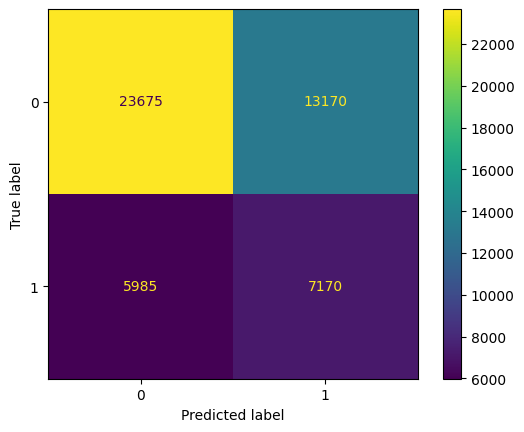

In [27]:
print_metrics_cv(best_logit_und,"LogisticRegression_UN")
print("Testing:")
test_pred_logit_und = best_logit_und.predict(X_sc_test)

print_report_score(y_test,test_pred_logit_und)
print_confusion_matrix(y_test,test_pred_logit_und,best_logit_und)

## KNN

KNN works using a distance function, but distance can not be applied to categorical data. We need to handle categorical values, for example we could drop them.

We define the KNN calssifier by specifying the algorithm and the distance metric to use and we fit it to our data.

Attempt with only class weights (described in report)

In [28]:
metrics = [
    'euclidean', 
    'minkowski',
    'chebyshev',
    'cosine',
    ]
params = {
        "unique_entry":{
        'n_neighbors': [5,7,9,15,30],
        'algorithm':['auto','ball_tree'], 
        'metric':metrics, 
        'weights':["distance","uniform"],
        'p': [1] # to include also manhattan distance (only valid with minkowski distance)
        }}
         
""" best_knn = do_sklearn_GridSearchCV("KNeighborsClassifier",KNeighborsClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl,y_trvl) """

' best_knn = do_sklearn_GridSearchCV("KNeighborsClassifier",KNeighborsClassifier(),list_grids(params), [\'accuracy\', \'precision\', \'recall\', \'f1\', \'roc_auc\'],"accuracy",\n                        cv_strategy,True,5,X_sc_trvl,y_trvl) '

In [29]:
""" print_metrics_cv(best_knn,"KNeighborsClassifier")
print("Testing:")
test_pred_knn = best_knn.predict(X_sc_test)

print_report_score(y_test,test_pred_knn)
print_confusion_matrix(y_test,test_pred_knn,best_knn) """

' print_metrics_cv(best_knn,"KNeighborsClassifier")\nprint("Testing:")\ntest_pred_knn = best_knn.predict(X_sc_test)\n\nprint_report_score(y_test,test_pred_knn)\nprint_confusion_matrix(y_test,test_pred_knn,best_knn) '

In [30]:
#plt.scatter(X_sc_test.iloc[:, 3].values, y_test.iloc[:, 6].values, c=test_pred_knn.values, s=25, cmap='YlGn')


Oversampling (attempt described on report)

In [31]:
""" best_knn_ov = do_sklearn_GridSearchCV("KNeighborsClassifier_OV",KNeighborsClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl_oversampled,y_trvl_oversampled) """

' best_knn_ov = do_sklearn_GridSearchCV("KNeighborsClassifier_OV",KNeighborsClassifier(),list_grids(params), [\'accuracy\', \'precision\', \'recall\', \'f1\', \'roc_auc\'],"accuracy",\n                        cv_strategy,True,5,X_sc_trvl_oversampled,y_trvl_oversampled) '

In [32]:
""" print_metrics_cv(best_knn_ov,"KNeighborsClassifier_OV")
print("Testing:")
test_pred_knn_ov = best_knn_ov.predict(X_sc_test)

print_report_score(y_test,test_pred_knn_ov)
print_confusion_matrix(y_test,test_pred_knn_ov,best_knn_ov) """

' print_metrics_cv(best_knn_ov,"KNeighborsClassifier_OV")\nprint("Testing:")\ntest_pred_knn_ov = best_knn_ov.predict(X_sc_test)\n\nprint_report_score(y_test,test_pred_knn_ov)\nprint_confusion_matrix(y_test,test_pred_knn_ov,best_knn_ov) '

Undersampling

In [33]:
best_knn_und = do_sklearn_GridSearchCV("KNeighborsClassifier_UN",KNeighborsClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,2,X_sc_trvl_undersample,y_trvl_undersample)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


c:\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Python310\lib\site-packages\sklearn\neighbors\_classification.py", line 215, in fit
    return self._fit(X, y)
  File "c:\Python310\lib\site-packages\sklearn\neighbors\_base.py", line 493, in _fit
    self._check_algorithm_metric()
  File "c:\Python310\lib\site-packages\sklearn\neighbors\_base.py", line 434, in _check_al

CV best configuration for KNeighborsClassifier_UN:
best parameters {'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
Mean accuracy train set: 0.9994380192213714 +/- 5.553910122574011e-05
Mean precision train set: 1.0 +/- 0.0
Mean recall train set: 0.9988760384427431 +/- 0.00011107820245141836
Mean f1 train set: 0.9994377001317123 +/- 5.559941482679296e-05
Mean roc_auc train set: 0.9999993621860254 +/- 1.2059236069253515e-07


Mean accuracy validation set: 0.6855839713308357 +/- 0.005155659294920563
Mean precision validation set: 0.6803893471418073 +/- 0.004890498790628284
Mean recall validation set: 0.6999837107020687 +/- 0.006781827699038708
Mean f1 validation set: 0.6900399203947775 +/- 0.005411984011442847
Mean roc_auc validation set: 0.7546127064855578 +/- 0.005895476144164077


Testing:
              precision    recall  f1-score   support

   NotKilled       0.86      0.68      0.76     36845
    isKilled       0.44      0.70      0.54

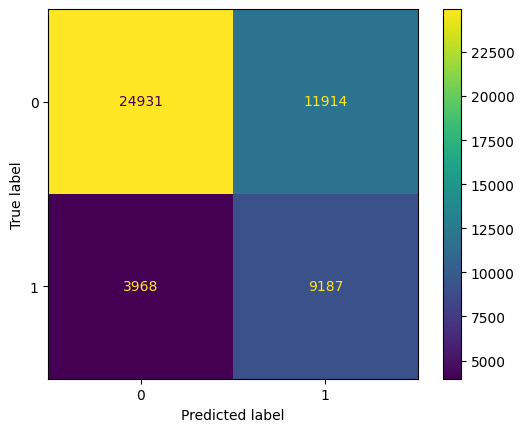

In [34]:
print_metrics_cv(best_knn_und,"KNeighborsClassifier_UN")
print("Testing:")
test_pred_knn_und = best_knn_und.predict(X_sc_test)

print_report_score(y_test,test_pred_knn_und)
print_confusion_matrix(y_test,test_pred_knn_und,best_knn_und)

## Naive Bayes

Bayes theorem is used to compute the probability of an instance belonging to a given class given some prior knowledge.
We fit the model on our training data.

We chose the best among the classifiers, based on validation set and tested it.

In [35]:
from sklearn.naive_bayes import GaussianNB

best_gnb_cv = do_sklearn_GridSearchCV("GaussianNB",GaussianNB(),{}, ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,2,X_trvl,y_trvl)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [36]:
print_metrics_cv(results_hp_search=best_gnb_cv, model_name='GaussianNB')

CV best configuration for GaussianNB:
best parameters {}
Mean accuracy train set: 0.7140013202407437 +/- 0.00023581205557581314
Mean precision train set: 0.4021689198462356 +/- 0.0015751676600531364
Mean recall train set: 0.17886463593419125 +/- 0.00200139730293633
Mean f1 train set: 0.24760329045904522 +/- 0.002198265315145425
Mean roc_auc train set: 0.6163205270905514 +/- 0.0009079453740915336


Mean accuracy validation set: 0.7139134608685 +/- 0.0015857081015749862
Mean precision validation set: 0.40180765024130666 +/- 0.005749060876277438
Mean recall validation set: 0.178628441114188 +/- 0.004603391332548339
Mean f1 validation set: 0.24727833076940256 +/- 0.004884168860730409
Mean roc_auc validation set: 0.6157671253618865 +/- 0.001879299463378557




In [37]:
from sklearn.naive_bayes import BernoulliNB

best_bnb_cv = do_sklearn_GridSearchCV("BernoulliNB",BernoulliNB(),{}, ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,2,X_trvl,y_trvl)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [38]:
print_metrics_cv(results_hp_search=best_bnb_cv, model_name='BernoulliNB')

CV best configuration for BernoulliNB:
best parameters {}
Mean accuracy train set: 0.7368854144775995 +/- 1.3384625578147008e-05
Mean precision train set: 0.4518253968253968 +/- 0.06664757852204464
Mean recall train set: 0.00016289297931259162 +/- 3.642397748004218e-05
Mean f1 train set: 0.00032566659946709934 +/- 7.281089004159787e-05
Mean roc_auc train set: 0.5754569606592478 +/- 0.0005742588645887277


Mean accuracy validation set: 0.7368854137851598 +/- 5.353941456425858e-05
Mean precision validation set: 0.4333333333333333 +/- 0.38873012632302
Mean recall validation set: 0.00016289297931259162 +/- 0.00014569590992016872
Mean f1 validation set: 0.000325626842010756 +/- 0.0002912257933025734
Mean roc_auc validation set: 0.5750097415038677 +/- 0.0016117107547284177




In [39]:
from sklearn.naive_bayes import MultinomialNB

best_mnb_cv = do_sklearn_GridSearchCV("MultinomialNB",MultinomialNB(),{}, ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,2,X_trvl,y_trvl)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [40]:
print_metrics_cv(results_hp_search=best_mnb_cv, model_name='MultinomialNB')

CV best configuration for MultinomialNB:
best parameters {}
Mean accuracy train set: 0.5278020645022986 +/- 0.000330449518647125
Mean precision train set: 0.27652972831053857 +/- 0.00032890402829584465
Mean recall train set: 0.49170060270402355 +/- 0.001690166752390643
Mean f1 train set: 0.3539814648514273 +/- 0.0006902492801689439
Mean roc_auc train set: 0.52326182913162 +/- 0.00012077943251205574


Mean accuracy validation set: 0.5278406210828605 +/- 0.0035909598433523115
Mean precision validation set: 0.27658050877762974 +/- 0.0026942244747956297
Mean recall validation set: 0.49177390454471415 +/- 0.004983566880853023
Mean f1 validation set: 0.35403660049841335 +/- 0.003179145464582208
Mean roc_auc validation set: 0.5232404182068546 +/- 0.0034654464455700844




In [41]:
from sklearn.naive_bayes import ComplementNB

best_cnb_cv = do_sklearn_GridSearchCV("ComplementNB",ComplementNB(),{}, ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,2,X_trvl,y_trvl)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [42]:
print_metrics_cv(results_hp_search=best_cnb_cv, model_name='ComplementNB')

CV best configuration for ComplementNB:
best parameters {}
Mean accuracy train set: 0.5192347255308171 +/- 0.0002568846860054174
Mean precision train set: 0.27634408246413344 +/- 0.00018667356936347308
Mean recall train set: 0.5110767225932562 +/- 0.000486638515924093
Mean f1 train set: 0.3587230842837072 +/- 0.0002502293656874529
Mean roc_auc train set: 0.5231567776349746 +/- 9.72161437479855e-05


Mean accuracy validation set: 0.5189861420150532 +/- 0.0032459694993043123
Mean precision validation set: 0.2761825715812601 +/- 0.0022331901408846034
Mean recall validation set: 0.5109626975077374 +/- 0.004391952395549845
Mean f1 validation set: 0.3585539736030108 +/- 0.0026402923404276906
Mean roc_auc validation set: 0.5231534574960195 +/- 0.003477109811683079




Best so far is GaussianNB, we testing it also with oversampling and undersampling techniques.

Testing:
              precision    recall  f1-score   support

   NotKilled       0.76      0.90      0.82     36845
    isKilled       0.40      0.18      0.25     13155

    accuracy                           0.71     50000
   macro avg       0.58      0.54      0.54     50000
weighted avg       0.66      0.71      0.67     50000



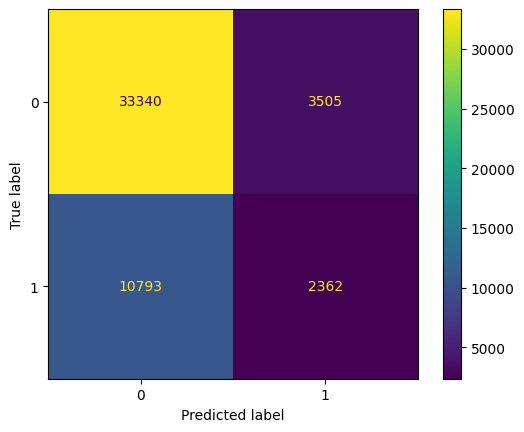

In [43]:
print("Testing:")
test_pred_gnb = best_gnb_cv.predict(X_test)
print_report_score(y_test,test_pred_gnb)
print_confusion_matrix(y_test,test_pred_gnb,best_gnb_cv)

oversampling (attempt, described on report)

In [44]:
""" best_gnb_balanced_ov = do_sklearn_GridSearchCV("GaussianNB_OV",GaussianNB(),{}, ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_trvl_oversampled,y_trvl_oversampled) """


' best_gnb_balanced_ov = do_sklearn_GridSearchCV("GaussianNB_OV",GaussianNB(),{}, [\'accuracy\', \'precision\', \'recall\', \'f1\', \'roc_auc\'],"accuracy",\n                        cv_strategy,True,5,X_trvl_oversampled,y_trvl_oversampled) '

In [45]:
""" print_metrics_cv(best_gnb_balanced_ov,"GaussianNB_OV")
print("Testing:")
test_pred_gnb_over = best_gnb_balanced_ov.predict(X_test)

print_report_score(y_test,test_pred_gnb_over)
print_confusion_matrix(y_test,test_pred_gnb_over,best_gnb_balanced_ov) """

' print_metrics_cv(best_gnb_balanced_ov,"GaussianNB_OV")\nprint("Testing:")\ntest_pred_gnb_over = best_gnb_balanced_ov.predict(X_test)\n\nprint_report_score(y_test,test_pred_gnb_over)\nprint_confusion_matrix(y_test,test_pred_gnb_over,best_gnb_balanced_ov) '

Undersampling

In [46]:
best_gnb_balanced_und = do_sklearn_GridSearchCV("GaussianNB_UN",GaussianNB(),{}, ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,2,X_trvl_undersample,y_trvl_undersample)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


CV best configuration for GaussianNB_UN:
best parameters {}
Mean accuracy train set: 0.5760180811207036 +/- 0.0014241845061489613
Mean precision train set: 0.6150494836085658 +/- 0.0014622920071811043
Mean recall train set: 0.4064505619807786 +/- 0.009063878274101352
Mean f1 train set: 0.4893856148994319 +/- 0.006306862160939497
Mean roc_auc train set: 0.6178359397713624 +/- 0.001806445602234577


Mean accuracy validation set: 0.5752728457403485 +/- 0.0021471000161891332
Mean precision validation set: 0.6137999927251231 +/- 0.0030489102430526034
Mean recall validation set: 0.40605961883042846 +/- 0.008296611342448301
Mean f1 validation set: 0.4887175717874236 +/- 0.006016550519803599
Mean roc_auc validation set: 0.6171234882946444 +/- 0.0025302927935629328


Testing:
              precision    recall  f1-score   support

   NotKilled       0.78      0.75      0.76     36845
    isKilled       0.36      0.40      0.38     13155

    accuracy                           0.66     50000
   m

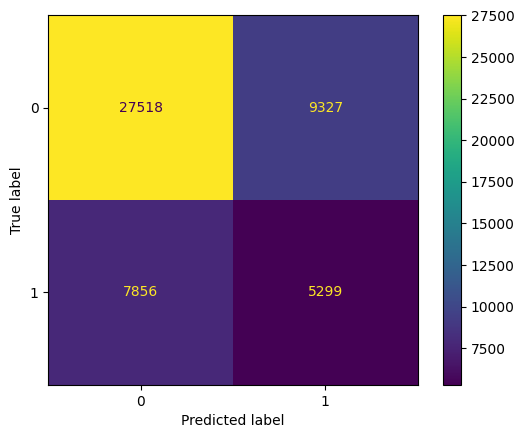

In [47]:
print_metrics_cv(best_gnb_balanced_und,"GaussianNB_UN")
print("Testing:")
test_pred_gnb_und = best_gnb_balanced_und.predict(X_test)

print_report_score(y_test,test_pred_gnb_und)
print_confusion_matrix(y_test,test_pred_gnb_und,best_gnb_balanced_und)

We plotted the scatter plot for the classification values on the test set.

In [48]:
#plt.scatter(X_test.iloc[:, 5], X_test.iloc[:, 6], c=test_pred_gnb, s=25, cmap='YlGn')

## Decision tree

We fit the decision tree on our training data.

In [49]:
params = {
        "unique_entry": {
        'criterion': ['gini', 'entropy','log_loss'],
        'max_depth': [5,10,None],
        'max_features': ['sqrt', 'log2', None],
        'min_samples_split': [2,8,16],
        'min_samples_leaf': [1,2,4,8]
        }
        }

This yields the following decision tree.

In [50]:
""" dot_data = export_graphviz(best_tree_cv.best_estimator_, out_file=None, 
                         feature_names=list(X_trvl.columns),  
                         class_names=['0', '1'],
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) """

" dot_data = export_graphviz(best_tree_cv.best_estimator_, out_file=None, \n                         feature_names=list(X_trvl.columns),  \n                         class_names=['0', '1'],\n                         filled=True, rounded=True)  \ngraph = pydotplus.graph_from_dot_data(dot_data)  \nImage(graph.create_png()) "

In [51]:
# TODO We plotted the scatter plot for the classification values on the test set 
#plt.scatter(X_sc_test.iloc[:, 5].values, X_sc_test.iloc[:, 2].values, c=test_pred_dt.values, s=25, cmap='YlGn')

Undersampling 

In [52]:
best_tree_balanced_und = do_sklearn_GridSearchCV("DecisionTreeClassifier_UN",DecisionTreeClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,3,X_sc_trvl_undersample,y_trvl_undersample)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


CV best configuration for DecisionTreeClassifier_UN:
best parameters {'criterion': 'log_loss', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 16}
Mean accuracy train set: 0.7359179019384265 +/- 0.002149732227353962
Mean precision train set: 0.7086654388919367 +/- 0.0037434502678735412
Mean recall train set: 0.8013683010262259 +/- 0.010095475555487884
Mean f1 train set: 0.7521181903906271 +/- 0.0031802306583616495
Mean roc_auc train set: 0.8153691972095867 +/- 0.001249032332888067


Mean accuracy validation set: 0.7122984199381006 +/- 0.005225184293687143
Mean precision validation set: 0.6873264261142606 +/- 0.007931227901749131
Mean recall validation set: 0.7794103274148884 +/- 0.008040645622625764
Mean f1 validation set: 0.730402891036416 +/- 0.003114993954480276
Mean roc_auc validation set: 0.7791064931359806 +/- 0.005119273672335723


Testing:
              precision    recall  f1-score   support

   NotKilled       0.90      0.60      0.72     36

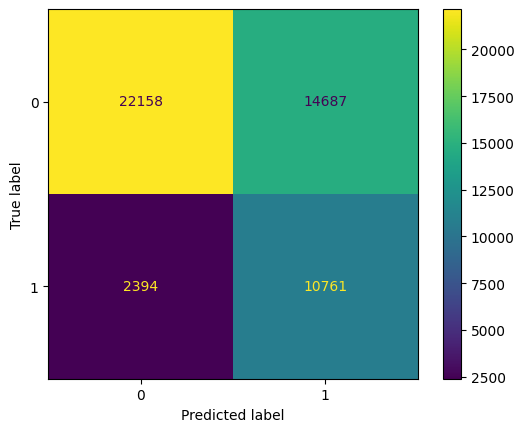

In [53]:
print_metrics_cv(results_hp_search=best_tree_balanced_und, model_name='DecisionTreeClassifier_UN')

print("Testing:")
test_pred_dt_und = best_tree_balanced_und.predict(X_sc_test)
print_report_score(y_test,test_pred_dt_und)
print_confusion_matrix(y_test,test_pred_dt_und,best_tree_balanced_und)

## SVM

In [51]:
params = {
  "linear_rbf_sigmoid": {
   "kernel": ['linear', 'rbf','sigmoid'],
   "C":[1e-2,1e1,1e2],
   "gamma" : ['scale', 'auto']
  },
  "poly": {
    "kernel": ['poly'],
    "C":[1e-2,1e1,1e2],
    "degree": [2,3,5],
    "gamma" : ['scale', 'auto']
  }
    } 

Undersampling

In [ ]:
best_svc_und = do_sklearn_GridSearchCV("SVC_UN",SVC(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,3,X_sc_trvl_undersample,y_trvl_undersample)

CV best configuration for SVC_UN:
best parameters {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}
Mean accuracy train set: 0.7151531194005538 +/- 0.001084538838424572
Mean precision train set: 0.6929042521658422 +/- 0.0012508885066055857
Mean recall train set: 0.7728294510506597 +/- 0.002179298654095733
Mean f1 train set: 0.7306853853699375 +/- 0.0010988727976457707
Mean roc_auc train set: 0.7980151726624454 +/- 0.0010134021526421574


Mean accuracy validation set: 0.6815442254438834 +/- 0.004081436295830044
Mean precision validation set: 0.6628231465464506 +/- 0.003507760837208264
Mean recall validation set: 0.7390454471412282 +/- 0.007491660453783257
Mean f1 validation set: 0.6988472203469437 +/- 0.004530893802565228
Mean roc_auc validation set: 0.7477556443982845 +/- 0.004796050426098621


Testing:
              precision    recall  f1-score   support

   NotKilled       0.87      0.62      0.72     36845
    isKilled       0.41      0.75      0.53     13155

    accuracy            

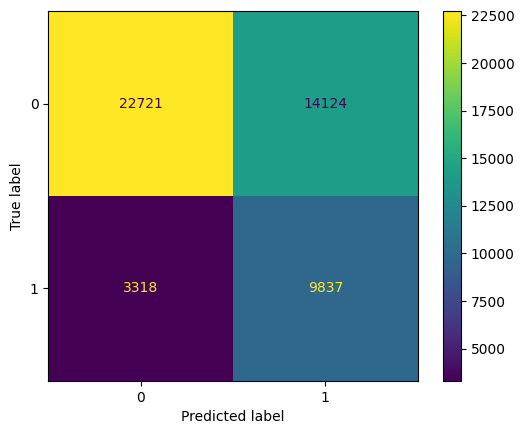

In [54]:
print_metrics_cv(best_svc_und,"SVC_UN")
print("Testing:")
test_pred_svc_und = best_svc_und.predict(X_sc_test)

print_report_score(y_test,test_pred_svc_und)
print_confusion_matrix(y_test,test_pred_svc_und,best_svc_und)

In [ ]:
#plt.scatter(X_sc_test.iloc[:, 3].values, y_test.iloc[:, 6].values, c=test_pred_svc.values, s=25, cmap='YlGn')

## Rule-based classification

In order to run the RIPPER classifier, we run a grip search to find the best configuration parameter values.
In particular, the prune size defines the grow/prune proportion , while k is the number of optimization runs.

In [ ]:
import wittgenstein as lw

In [ ]:
params = {
    "unique_entry":{
    "prune_size": [0.5, 0.6], 
    "k": [1, 3, 5],
    "random_state":[10]
    }}

best_ripper_und = do_sklearn_GridSearchCV("RIPPER_UN",lw.RIPPER(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,3,X_sc_trvl_undersample,y_trvl_undersample)

The rules yielded by the RIPPER model are the following.

In [ ]:
best_ripper_und.best_estimator_.out_model()

We predict the class values using the rules found above.

In order to evaluate the goodness of this classfication we compute the performance metrics.

In [ ]:
print_metrics_cv(best_ripper_und,"RIPPER_UN")
print("Testing:")
test_pred_ripper_und = best_ripper_und.predict(X_sc_test)

print_report_score(y_test,test_pred_ripper_und)
print_confusion_matrix(y_test,test_pred_ripper_und,best_ripper_und)


with rule based classifiers it is possible to extract the reasons for the prediction.
only for the positive predictions

In [ ]:
best_ripper_und.best_estimator_.predict(X_sc_test[:20], give_reasons=True) #Explain the rules behind the first 20 instances that are classified as positive.

## Neural Network

imports of libraries to create NN

In [34]:
from sklearn.neural_network import MLPClassifier

We start by considering a neural network composed by one layer.

In [35]:
#custom mse metric for sklearn GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

custom_scores_mlp = {
    "accuracy": "accuracy",
    "mse": make_scorer(mean_squared_error,greater_is_better=False),
    'precision': 'precision',
    'recall': 'recall', 
    'f1':'f1', 
    'roc_auc': 'roc_auc'
}

In [36]:
# These parameters are a selection from a more coarse grid search
params = {
    "unique_entry":{
    "hidden_layer_sizes": [[64],[32,16],[16,32],[64, 32, 8]], #[4], [16], [32],
    "activation": ["tanh", ], #"logistic"
    "solver": ["adam", "sgd"], 
    "alpha": [1e-5, 1e-8],
    "batch_size": [8, 32],
    "learning_rate_init": [1e-2, 5e-3],
    "learning_rate": ['constant'],
    "max_iter": [500]
}
}



In [ ]:
""" 
from sklearn.model_selection import learning_curve
#Reconstructing curve of best model
train_sizes, train_scores, test_scores = learning_curve( MLPClassifier(hidden_layer_sizes=[12], activation="tanh", 
                 solver="adam"), X_sc_trvl, y_trvl, cv=2, scoring=custom_scores_mlp["mse"])

train_scores_mean = np.mean(abs(train_scores), axis=1)
test_scores_mean = np.mean(abs(test_scores), axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, '-', color="b", label="Training score")
plt.plot(train_sizes, test_scores_mean, '-', color="r", label="Validation score")
plt.xlabel("Training examples")
plt.ylabel("MSE")
plt.legend(loc="best")
plt.title("Learning Curve for MLP")
plt.show() """

undersampling

In [37]:
best_mlp_und = do_sklearn_GridSearchCV("MLP_UN",MLPClassifier(),list_grids(params), custom_scores_mlp,"mse",
                        cv_strategy,True,4,X_sc_trvl_undersample,y_trvl_undersample)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[CV 1/5; 1/64] START activation=tanh, alpha=1e-05, batch_size=8, hidden_layer_sizes=[64], learning_rate=constant, learning_rate_init=0.01, max_iter=500, solver=adam
[CV 2/5; 1/64] START activation=tanh, alpha=1e-05, batch_size=8, hidden_layer_sizes=[64], learning_rate=constant, learning_rate_init=0.01, max_iter=500, solver=adam
[CV 4/5; 1/64] START activation=tanh, alpha=1e-05, batch_size=8, hidden_layer_sizes=[64], learning_rate=constant, learning_rate_init=0.01, max_iter=500, solver=adam
[CV 3/5; 1/64] START activation=tanh, alpha=1e-05, batch_size=8, hidden_layer_sizes=[64], learning_rate=constant, learning_rate_init=0.01, max_iter=500, solver=adam
[CV 1/5; 1/64] END activation=tanh, alpha=1e-05, batch_size=8, hidden_layer_sizes=[64], learning_rate=constant, learning_rate_init=0.01, max_iter=500, solver=adam; accuracy: (train=0.727, test=0.716) f1: (train=0.753, test=0.743) mse: (train=-0.273, test=-0.284) precision: (train=0.687, test=0.678) recall: (train=0.833, test=0.821) roc_au

CV best configuration for MLP_UN:
best parameters {'activation': 'tanh', 'alpha': 1e-08, 'batch_size': 32, 'hidden_layer_sizes': [64], 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'max_iter': 500, 'solver': 'adam'}
Mean accuracy train set: 0.7301311288483466 +/- 0.0019683023368213272
Mean precision train set: 0.7073461672333586 +/- 0.004642065364695154
Mean recall train set: 0.7854536569473856 +/- 0.018874942383513733
Mean f1 train set: 0.7441832982923646 +/- 0.005930555300998444
Mean roc_auc train set: 0.8068235800045326 +/- 0.0018529179530501216


Mean accuracy validation set: 0.7209480371395993 +/- 0.003122875511541879
Mean precision validation set: 0.6993349010763164 +/- 0.008110508878408905
Mean recall validation set: 0.775859260465874 +/- 0.017722576486925073
Mean f1 validation set: 0.7354086060201306 +/- 0.004653900688080633
Mean roc_auc validation set: 0.7932951615212979 +/- 0.004552152111410036


Testing:
              precision    recall  f1-score   support

   N

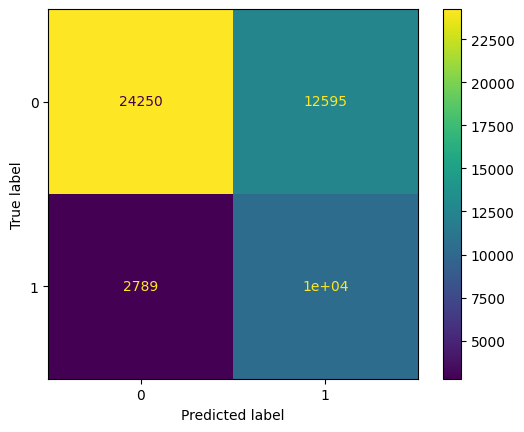

In [38]:
print_metrics_cv(best_mlp_und,"MLP_UN")
print("Testing:")
test_pred_mlp_und = best_mlp_und.predict(X_sc_test)

print_report_score(y_test,test_pred_mlp_und)
print_confusion_matrix(y_test,test_pred_mlp_und,best_mlp_und)

## Ensemble methods

### Random Forest

#### Grid search for parameter setting

In order to find the best parameters we use a grid search.
The parameters values we want to find are the following.

In [ ]:
params = {
    "unique_entry": {
    'max_depth': [5, 15, None],
    'max_features': ['log2', None],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [32, 64, 128],
    "bootstrap": [True, False],
    "criterion": ["entropy", "gini"]
    }}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[CV] END .................................................... total time=  10.3s
[CV] END .................................................... total time=  10.5s
[CV] END .................................................... total time=  10.9s
[CV] END .................................................... total time=   9.7s
[CV] END .................................................... total time=  10.3s


We run the classifier and compute the perfomance scores.

In [ ]:
best_rf_und = do_sklearn_GridSearchCV("RandomForestClassifier_UN",RandomForestClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,3,X_sc_trvl_undersample,y_trvl_undersample)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
#plt.scatter(X_sc_test.iloc[:, 3].values, y_test.iloc[:, 6].values, c=test_pred_rf.values, s=25, cmap='YlGn')


CV best configuration for RandomForestClassifier_UN:
best parameters {}
Mean accuracy train set: 0.7472869350543025 +/- 0.0035881674653820204
Mean precision train set: 0.6755262791363921 +/- 0.0031232752368840237
Mean recall train set: 0.9517439259906961 +/- 0.0013639834406489074
Mean f1 train set: 0.7901899694428481 +/- 0.002579256998283355
Mean roc_auc train set: 0.8957640153162556 +/- 0.0009369164146972369


Mean accuracy validation set: 0.7469724862531922 +/- 0.005159216115391393
Mean precision validation set: 0.6752703022472477 +/- 0.004355558191444009
Mean recall validation set: 0.9515897879299813 +/- 0.002372455244529954
Mean f1 validation set: 0.7899607586952313 +/- 0.0037909706247199687
Mean roc_auc validation set: 0.8956185014373903 +/- 0.001499188440156002


Testing:
              precision    recall  f1-score   support

   NotKilled       0.99      0.99      0.99     43106
    isKilled       0.97      0.96      0.97     13155

    accuracy                           0.99    

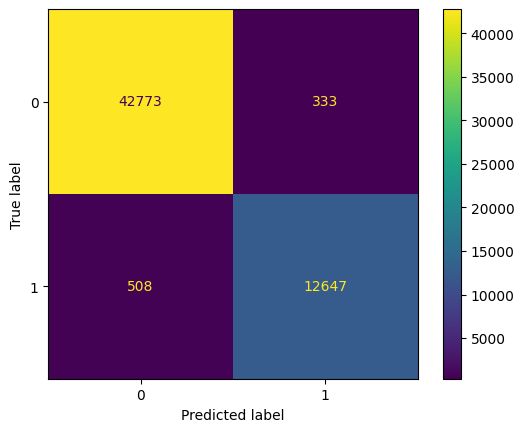

In [ ]:
print_metrics_cv(best_rf_und,"RandomForestClassifier_UN")

print("Testing:")
test_pred_rf_und = best_rf_und.predict(X_sc_test)

print_report_score(y_test,test_pred_rf_und)
print_confusion_matrix(y_test,test_pred_rf_und,best_rf_und)

### AdaBoost

Grid search AdaBoost

In [39]:

def getAdaBoostBaseAlgo(num):
    if num == 0:
        return DecisionTreeClassifier(criterion='log_loss', max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=16)
    elif num == 1:
        return SVC(C=10.0, gamma='scale', kernel='rbf')
    elif num == 2:
        return LogisticRegression(C=0.1, penalty='l1', solver='liblinear')
                


In [40]:
params = {
    "unique_entry":{
    'estimator': [getAdaBoostBaseAlgo(0),getAdaBoostBaseAlgo(2), getAdaBoostBaseAlgo(1)],
    'n_estimators': [10,30,100], # The maximum number of estimators at which boosting is terminated.
    'learning_rate': [0.1,0.05],
    'random_state': [42],
    'algorithm': ['SAMME']
    }
    }

Undersampling

In [41]:
best_ada_boost_und = do_sklearn_GridSearchCV("AdaBoostClassifier_UN",AdaBoostClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,4,X_sc_trvl_undersample,y_trvl_undersample)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[CV 1/5; 1/18] START algorithm=SAMME, estimator=DecisionTreeClassifier(criterion='log_loss', max_depth=10, min_samples_leaf=4,
                       min_samples_split=16), learning_rate=0.1, n_estimators=10, random_state=42
[CV 4/5; 1/18] START algorithm=SAMME, estimator=DecisionTreeClassifier(criterion='log_loss', max_depth=10, min_samples_leaf=4,
                       min_samples_split=16), learning_rate=0.1, n_estimators=10, random_state=42
[CV 2/5; 1/18] START algorithm=SAMME, estimator=DecisionTreeClassifier(criterion='log_loss', max_depth=10, min_samples_leaf=4,
                       min_samples_split=16), learning_rate=0.1, n_estimators=10, random_state=42
[CV 3/5; 1/18] START algorithm=SAMME, estimator=DecisionTreeClassifier(criterion='log_loss', max_depth=10, min_samples_leaf=4,
                       min_samples_split=16), learning_rate=0.1, n_estimators=10, random_state=42
[CV 3/5; 1/18] END algorithm=SAMME, estimator=DecisionTreeClassifier(criterion='log_loss', max_depth

KeyboardInterrupt: 

CV best configuration for AdaBoostClassifier_UN:
best parameters {}
Mean accuracy train set: 0.9735590811594964 +/- 0.0012201361355250512
Mean precision train set: 0.9868393443904301 +/- 0.0005547711576688695
Mean recall train set: 0.9599191726798655 +/- 0.0019934095522113433
Mean f1 train set: 0.9731924750601337 +/- 0.001257206335518299
Mean roc_auc train set: 0.9956742403819426 +/- 5.975593505442413e-05


Mean accuracy validation set: 0.9735081124442317 +/- 0.00127796892476267
Mean precision validation set: 0.9867042635179051 +/- 0.0009242597209341455
Mean recall validation set: 0.9599514770582177 +/- 0.0020365875755922283
Mean f1 validation set: 0.9731431696306793 +/- 0.0013123026908192722
Mean roc_auc validation set: 0.9956327291221518 +/- 0.00017370587718313756


Testing:
              precision    recall  f1-score   support

   NotKilled       0.99      0.99      0.99     43106
    isKilled       0.96      0.96      0.96     13155

    accuracy                           0.98     

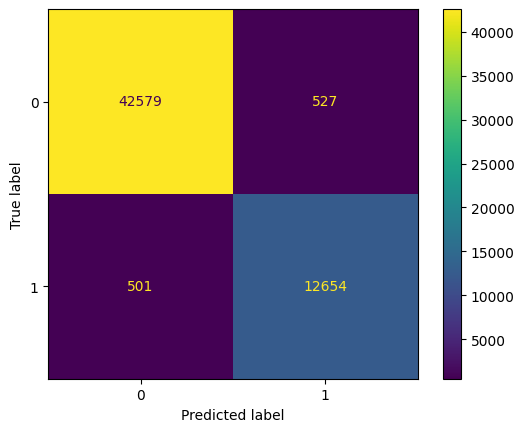

In [ ]:
print_metrics_cv(best_ada_boost_und,"AdaBoostClassifier_UN")
print("Testing:")
test_pred_ada_boost_und = best_ada_boost_und.predict(X_sc_test)

print_report_score(y_test,test_pred_ada_boost_und)
print_confusion_matrix(y_test,test_pred_ada_boost_und,best_ada_boost_und)

In [ ]:
#plt.scatter(X_sc_test.iloc[:, 3].values, y_test.iloc[:, 6].values, c=test_pred_ada_boost.values, s=25, cmap='YlGn')

## ROC Curve

We plot the ROC curve in order to estimate the goodness of our classification.

In [ ]:
plt.figure(0).clf()

fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_ada_boost_und)
auc = metrics.roc_auc_score(y_test, test_pred_ada_boost_und)
plt.plot(fpr,tpr,label="AdaBoost, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_rf_und)
auc = metrics.roc_auc_score(y_test, test_pred_rf_und)
plt.plot(fpr,tpr,label="RandomForest, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_dt_und)
auc = metrics.roc_auc_score(y_test, test_pred_dt_und)
plt.plot(fpr,tpr,label="DecisionTree, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_knn_und)
auc = metrics.roc_auc_score(y_test, test_pred_knn_und)
plt.plot(fpr,tpr,label="KNN, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_svc_und)
auc = metrics.roc_auc_score(y_test, test_pred_svc_und)
plt.plot(fpr,tpr,label="SVM, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_gnb_und)
auc = metrics.roc_auc_score(y_test, test_pred_gnb_und)
plt.plot(fpr,tpr,label="Naive Bayes, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_mlp_und)
auc = metrics.roc_auc_score(y_test, test_pred_mlp_und)
plt.plot(fpr,tpr,label="MLP, auc="+str(auc))

plt.legend(loc=0)